<a href="https://colab.research.google.com/github/vperezr/sampleMisinformationDetector/blob/main/misinformationDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

dataset = 'https://raw.githubusercontent.com/vperezr/sampleMisinformationDetector/main/celeb_dataset.csv'

In [ ]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [ ]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [22]:
# read in our data and preprocess it

df = pd.read_csv(dataset,sep='\t')
df.drop(labels=['id','title'], axis='columns', inplace=True)


In [23]:
print (df)

                                                  text  label
0    \nJennifer Aniston is making Friends fans very...   fake
1    \nBrad Pitt and Jennifer Aniston have reported...   fake
2    \nJennifer Aniston, 47, has dreamed of becomin...   fake
3    \nJennifer Aniston is looking to adopt a baby ...   fake
4    \nBrad Pitt, 51, may not have been the only on...   fake
..                                                 ...    ...
495  \nBreak-ups are hard to handle, and no one kno...  legit
496  \nOwen Wilson is opening up about his kids’ po...  legit
497  \nAlthough news has since broke that Taylor Sw...  legit
498  \nRyan Seacrest not only takes the New York su...  legit
499  \nRadarOnline published a story about Caitlyn ...  legit

[500 rows x 2 columns]


In [48]:
# prepare text samples and their labels
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)
texts = df['text']
labels = df['label']
print('Found %s texts.' %texts.shape[0])



Found 500 texts.
0      Jennifer Aniston is making Friends fans very h...
1      Brad Pitt and Jennifer Aniston have reportedly...
2      Jennifer Aniston, 47, has dreamed of becoming ...
3      Jennifer Aniston is looking to adopt a baby fr...
4      Brad Pitt, 51, may not have been the only one ...
                             ...                        
495    Break-ups are hard to handle, and no one knows...
496    Owen Wilson is opening up about his kids’ pote...
497    Although news has since broke that Taylor Swif...
498    Ryan Seacrest not only takes the New York subw...
499    RadarOnline published a story about Caitlyn cl...
Name: text, Length: 500, dtype: object


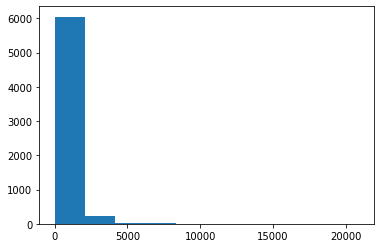

In [58]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Naive Bayes

In [60]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [61]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [62]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [64]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.91%
Testing Accuracy: 88.00%


In [65]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 86.21%-89.79%
